In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.set_printoptions(suppress=True)

In [2]:
import recordreader
K = np.load("../../tools/camcal/old/camera_matrix.npy")
dist = np.load("../../tools/camcal/old/dist_coeffs.npy")
K[:2] /= 4.05
fx, fy = np.diag(K)[:2]
cx, cy = K[:2, 2]
K

array([[188.34285935,   0.        , 319.28187167],
       [  0.        , 186.89236356, 230.05912278],
       [  0.        ,   0.        ,   1.        ]])

In [3]:
import ba
pts = ba.pts
ceilmask = ba.ceilmask
pts.shape

(1, 217407, 2)

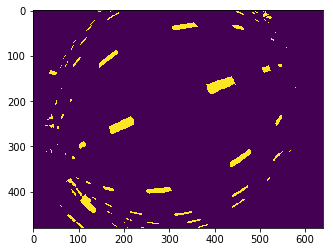

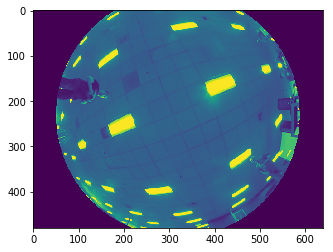

In [4]:
f = open("/opt/data/cycloid/cl20190420/cycloid-20190420-172107.rec", "rb")
ok, frame = recordreader.read_frame(f)
gray = frame['yuv420'][:480]
f.close()

plt.imshow(gray > 240)
plt.show()
plt.imshow(gray * ceilmask)

(-24.31748541198614,
 24.315820572502712,
 -21.965109512402982,
 21.267299760462656)

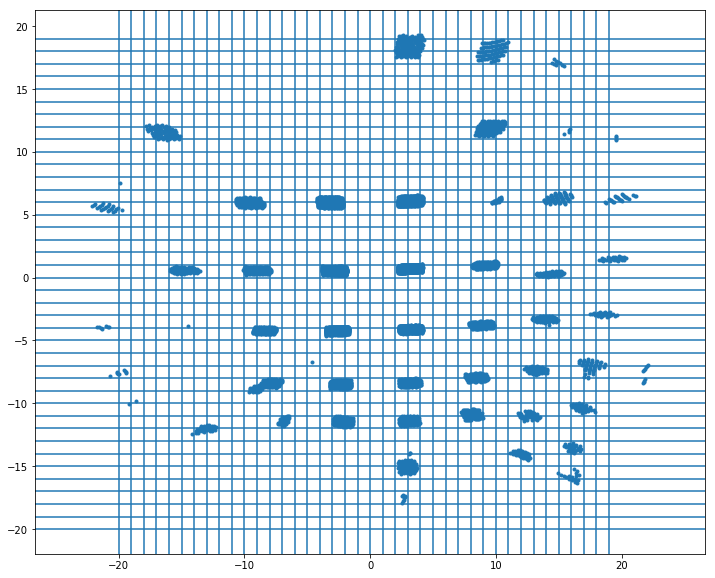

In [5]:
def remap(xi, yi, theta, Z, ceilpx):
    S, C = np.sin(theta), np.cos(theta)
    R = np.array([[C, S], [-S, C]])*Z
    p = np.dot(pts[0][ceilpx[ceilmask]], R.T) + np.array([xi, yi])
    return p

plt.figure(figsize=(12,10))
#xy = remap(0.7, -2, 1.2, 4, gray > 220)
#xy = remap(0.8, 1.8, 1.19, 4, gray > 220)
xy = remap(0, 0, 2.7284349649214974, 4, gray > 220)
plt.plot(*xy.T, '.')
for i in range(-20, 20):
    plt.axvline(i)
for j in range(-20, 20):
    plt.axhline(j)
plt.axis('equal')

In [6]:
n, msk = cv2.connectedComponents((ceilmask*gray > 220).astype(np.uint8))
np.argmax(np.histogram(msk, n)[0][1:])

14

In [7]:
np.linalg.svd(np.cov(remap(0, 0, 0, 4, msk == 16).T))

(array([[-0.9389737 ,  0.34398895],
        [ 0.34398895,  0.9389737 ]]),
 array([0.14578052, 0.00546715]),
 array([[-0.9389737 ,  0.34398895],
        [ 0.34398895,  0.9389737 ]]))

In [8]:
np.arctan2(0.4015, -0.91585)

2.7284349649214974

(-6.180538298152253, 6.080321432612703, -5.054322737679049, 5.907500761971042)

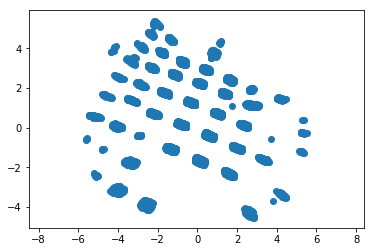

In [9]:
plt.scatter(*pts[0][msk[ceilmask] != 0].T)
plt.axis('equal')

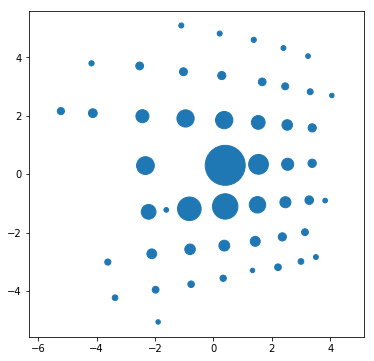

In [24]:
import ba

def features(greyimg, thr=230, minpix=20):
    # get ceiling light features from fisheye image
    n, msk = cv2.connectedComponents((ba.ceilmask*greyimg > thr).astype(np.uint8))
    F = []
    N = []
    C = []
    for i in range(n):
        P = ba.pts[0][msk[ba.ceilmask] == i+1]
        if P.shape[0] < minpix:
            continue
        N.append(P.shape[0])
        M = np.mean(P, axis=0)
        C.append(np.linalg.svd(np.cov((P - M).T))[0][:, 0])
        F.append(M)
    
    return np.array(F), np.array(N), np.array(C)

F, N, C = features(gray, 240)
plt.figure(figsize=(6,6))
plt.axis('equal')
orient = np.dot(N, C)
S, C = orient / np.linalg.norm(orient)
R = np.array([[C, -S], [S, C]])
plt.scatter(*np.dot(R, F.T), N)


In [496]:
lmframe = []

f = open("/opt/data/cycloid/cl20190420/cycloid-20190420-173131.rec", "rb")
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    F, N, C = features(gray, 239, 5)
    S, C = orient / np.linalg.norm(orient)
    #R = np.array([[C, -S], [S, C]])
    #x, y = np.dot(R, F.T)
    x, y = F.T
    img = np.zeros((480, 640, 3), np.uint8)
    l = []
    for i in range(len(x)):
        if N[i] > 250 and x[i]**2 < 4 and y[i]**2 < 4:
            c = (170, 255, 170)
            l.append([x[i], y[i], N[i]])
        else:
            c = (170, 170, 170)
        cv2.circle(img, (int(16*320 + x[i] * 800), int(16*240 + y[i] * 800)), int(8*np.sqrt(N[i])), c, shift=4)
    lmframe.append(l)
    cv2.imshow("map", img)
    cv2.imshow("gray", gray)
    
    k = cv2.waitKey(0)
    if k == ord('q'):
        break

f.close()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1

(-2.0833443224430086,
 1.8241548359394073,
 -2.0292764842510223,
 1.3183073937892913)

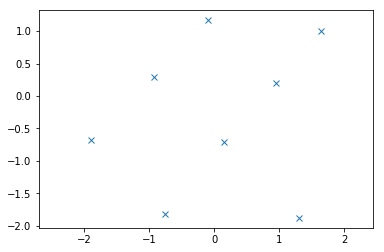

In [398]:
L = np.array(lmframe[0])
X = np.array([0., 0, 0])
plt.plot(L[:, 0], L[:, 1], 'x')
plt.axis('equal')

In [399]:
# cost_jk: min_i rho(R_j*L_k + X_j - L_i)
def cost(x, y, L):  # state, measurement, landmarks
    theta = x[2]
    S, C = np.sin(theta), np.cos(theta)
    R = np.array([[C, -S], [S, C]])
    #dR = np.array([[-S, -C], [C, -S]])
    # translate all landmarks into camera frame
    Lx = np.dot(R, (L[:, :2] - x[:2]).T)
    g = np.zeros(3)
    c = 0
    yi = np.zeros(len(y), np.int)
    for k, Lk in enumerate(y):
        DL = (Lk[:2] - Lx.T)
        cost = np.sum(DL**2, axis=1)
        i = np.argmin(cost)
        if cost[i] > 1:
            # add a new landmark
            Lkw = np.dot(R.T, Lk[:2]) + x[:2]
            yi[k] = L.shape[0]
            L = np.vstack([L, Lkw])
            continue
        yi[k] = i
        Lix, Liy = L[i, :2]
        Lkx, Lky = Lk[:2]
        x0 = S
        x1 = Lix - x[0]
        x2 = x0*x1
        x3 = C
        x4 = Liy - x[1]
        x5 = -Lky + x2 + x3*x4
        x6 = x1*x3
        x7 = x0*x4
        x8 = -Lkx + x6 - x7
        x9 = 2*x0
        x10 = 2*x3
        
        dx = -x10*x8 - x5*x9
        dy = -x10*x5 + x8*x9
        dtheta = x5*2*(x6 - x7) - x8*(x10*x4 + 2*x2)
        g += [Lk[2]*dx, Lk[2]*dy, Lk[2]*dtheta]
        c += cost[i]
    return c, g/1000., yi, L

cost([0.0, 0, 0], lmframe[200], np.array(lmframe[0])[:, :2])[:2]

(1.6607886881311014, array([ 0.20623492, -2.05487581, -1.32215324]))

In [400]:
# first pass, initial positions for landmarks and state
L = np.array(lmframe[0])[:, :2]
x = np.array([0., 0., 0.])
xs = []
xs.append(x.copy())
Lis = [np.arange(len(L))]
for j in range(1, len(lmframe)):
    for i in range(20):
        c, g, Li, L = cost(x, lmframe[j], L)
        x -= 0.02*g
    xs.append(x.copy())
    Lis.append(Li)


In [401]:
xs = np.array(xs)
xs.shape

(698, 3)

(-6.911531238720961, 3.8849367299098425, -5.177791096797609, 5.963908042168536)

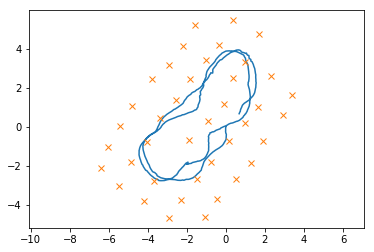

In [402]:
plt.plot(xs[:, 0], xs[:, 1])
plt.plot(L[:, 0], L[:, 1], 'x')
plt.axis('equal')

In [495]:
from scipy.sparse import lil_matrix

Nl = L.shape[0]
Nx = xs.shape[0]

# now we have all our assignments, we can run a dense bundle adjustment step pretty easily
def totalcost(X):
    L = X[:2*Nl].reshape((-1, 2))
    xs = X[2*Nl:].reshape((-1, 3))
    cost = []
    for i in range(0, len(xs)):
        x = xs[i]
        theta = x[2]
        S, C = np.sin(theta), np.cos(theta)
        R = np.array([[C, -S], [S, C]])
        Lx = np.dot(R, (L[:, :2] - x[:2]).T)
        d = np.array(lmframe[i])[:, :2] - Lx[:, Lis[i]].T
        cost.extend(d.reshape(-1))
    return np.float32(cost)

def totalsparsity():
    n = 2*Nl + 3*Nx
    m = 0
    for i in range(0, len(xs)):
        m += 2*len(Lis[i])
    s = lil_matrix((m, n), dtype=int)
    mi = 0
    for i in range(0, len(xs)):
        for j in range(len(Lis[i])):
            Lij = Lis[i][j]
            s[mi:mi+2, Lij*2:Lij*2+2] = 1
            s[mi:mi+2, 2*Nl + 3*i:2*Nl + 3*i+3] = 1
            mi += 2
    return s    

X = np.concatenate([L.reshape(-1), xs.reshape(-1)])
X.shape, totalcost(X).shape

IndexError: list index out of range

In [404]:
totalsparsity()

<10122x2174 sparse matrix of type '<class 'numpy.int64'>'
	with 50610 stored elements in LInked List format>

In [405]:
import scipy.optimize

res = scipy.optimize.least_squares(totalcost, X, jac_sparsity=totalsparsity(), loss='huber', verbose=2)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1536e+02                                    6.65e+01    
       1              2         2.7000e+01      8.84e+01       4.48e+00       1.88e+01    
       2              3         1.8088e+01      8.91e+00       1.69e+00       3.59e+00    
       3              4         1.7959e+01      1.28e-01       1.18e+00       4.01e+00    
       4              5         1.7870e+01      8.93e-02       2.96e-01       3.99e+00    
       5              6         1.7718e+01      1.52e-01       7.40e-02       2.86e+00    
       6              7         1.7693e+01      2.54e-02       7.40e-02       3.64e+00    
       7              8         1.7683e+01      9.20e-03       1.85e-02       2.58e+00    
       8              9         1.7677e+01      6.27e-03       4.63e-03       2.91e+00    
       9             14         1.7677e+01      9.67e-09       4.52e-06       1.98e+00    

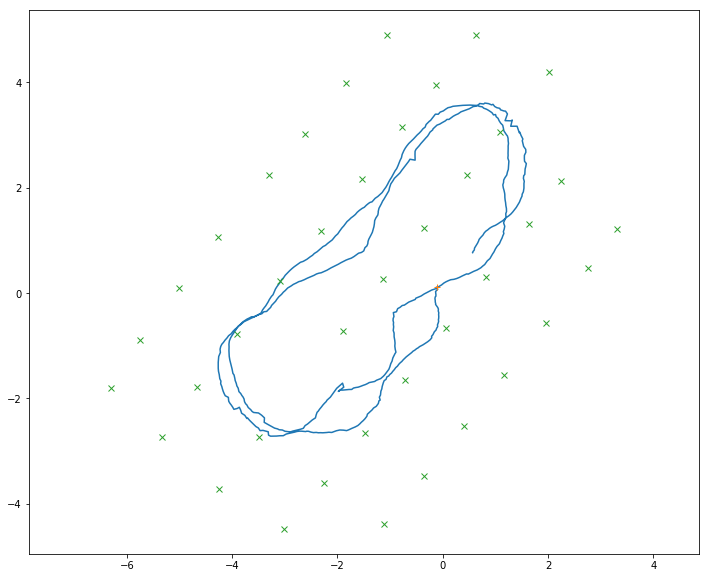

In [410]:
def showresult(X):
    plt.axis('equal')
    L = X[:2*Nl].reshape((-1, 2))
    xs = X[2*Nl:].reshape((-1, 3))
    plt.plot(xs[:, 0], xs[:, 1])
    plt.plot(xs[0, 0], xs[0, 1], '+')
    plt.plot(L[:, 0], L[:, 1], 'x')

plt.figure(figsize=(12,10))
showresult(res['x'])
#plt.plot(xs[:, 0], xs[:, 1])
#plt.plot(L[:, 0], L[:, 1], 'x')

In [425]:
f = open("/opt/data/cycloid/cl20190420/cycloid-20190420-173131.rec", "rb")
i = 0
acts = []
for frame in recordreader.RecordIterator(f):
    gray = frame['yuv420'][:480]
    act = frame['activations']
    acts.append(act[1:] - act[:-1])
f.close()
len(acts), len(xs)

(698, 698)

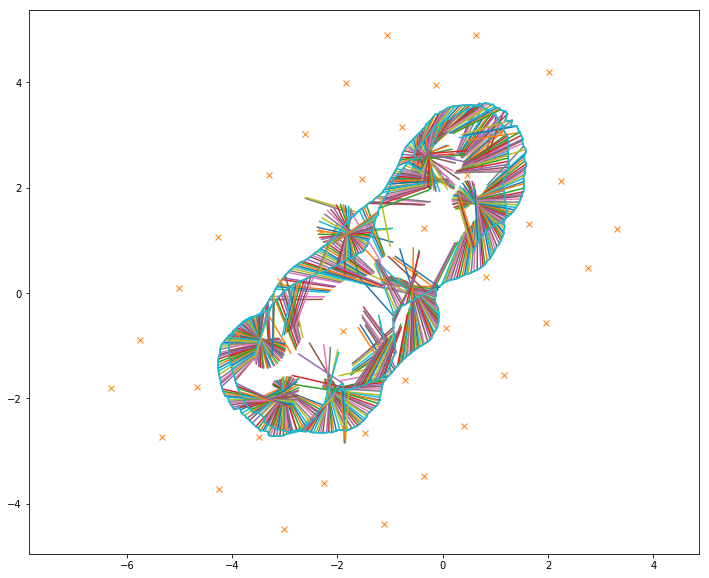

In [514]:
r = len(xs)
nxs = res['x'][2*Nl:].reshape((-1, 3))
angs = -np.pi/2 + 2*np.pi * np.argmax(acts[:r], axis=1) / len(acts[0])
plt.figure(figsize=(12,10))
plt.plot(nxs[:r, 0], nxs[:r, 1])
for i in range(r):
    plt.plot([nxs[i, 0], nxs[i, 0] + np.cos(angs[i] - nxs[i, 2])],
            [nxs[i, 1], nxs[i, 1] + np.sin(angs[i] - nxs[i, 2])])
#plt.plot(xs[:r, 0] + np.cos(angs), xs[:r, 1] + np.sin(angs), '.')
plt.axis('equal')
showresult(res['x'])


In [493]:
np.argmax(acts[0]) / len(acts[0])

0.7283298097251586

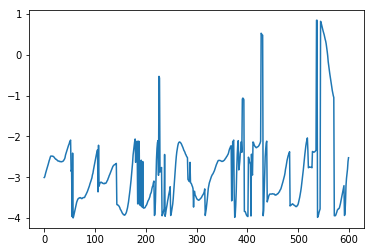

In [511]:
plt.plot(-angs)